# Overview of multiclass training meta-estimators

In this example, we discuss the problem of classification when the target variable is composed of more than two classes. This is called multiclass classification.

In scikit-learn, all estimators support multiclass classification out of the box: the most sensible strategy was implemented for the end-user. The sklearn.multiclass module implements various strategies that one can use for experimenting or developing third-party estimators that only support binary classification.

sklearn.multiclass includes OvO/OvR strategies used to train a multiclass classifier by fitting a set of binary classifiers (the OneVsOneClassifier and OneVsRestClassifier meta-estimators). This example will review them.

In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=181, as_frame=True, return_X_y=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
y.value_counts().sort_index()

class_protein_localization
CYT    463
ERL      5
EXC     35
ME1     44
ME2     51
ME3    163
MIT    244
NUC    429
POX     20
VAC     30
Name: count, dtype: int64

**Strategies comparison**

In the following experiment, we use a DecisionTreeClassifier and a RepeatedStratifiedKFold cross-validation with 3 splits and 5 repetitions.

We compare the following strategies:

- :class:~sklearn.tree.DecisionTreeClassifier can handle multiclass classification without needing any special adjustments. It works by breaking down the training data into smaller subsets and focusing on the most common class in each subset. By repeating this process, the model can accurately classify input data into multiple different classes.
- OneVsOneClassifier trains a set of binary classifiers where each classifier is trained to distinguish between two classes.
- OneVsRestClassifier: trains a set of binary classifiers where each classifier is trained to distinguish between one class and the rest of the classes.
- OutputCodeClassifier: trains a set of binary classifiers where each classifier is trained to distinguish between a set of classes from the rest of the classes. The set of classes is defined by a codebook, which is randomly generated in scikit-learn. This method exposes a parameter code_size to control the size of the codebook. We set it above one since we are not interested in compressing the class representation.

In [4]:
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.multiclass import (
    OneVsOneClassifier,
    OneVsRestClassifier,
    OutputCodeClassifier,
)
from sklearn.tree import DecisionTreeClassifier

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)

tree = DecisionTreeClassifier(random_state=0)
ovo_tree = OneVsOneClassifier(tree)
ovr_tree = OneVsRestClassifier(tree)
ecoc = OutputCodeClassifier(tree, code_size=2)

cv_results_tree = cross_validate(tree, X, y, cv=cv, n_jobs=2)
cv_results_ovo = cross_validate(ovo_tree, X, y, cv=cv, n_jobs=2)
cv_results_ovr = cross_validate(ovr_tree, X, y, cv=cv, n_jobs=2)
cv_results_ecoc = cross_validate(ecoc, X, y, cv=cv, n_jobs=2)

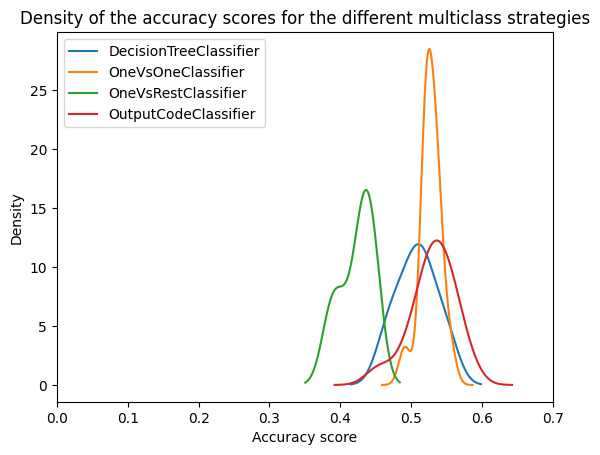

In [5]:
from matplotlib import pyplot as plt

scores = pd.DataFrame(
    {
        "DecisionTreeClassifier": cv_results_tree["test_score"],
        "OneVsOneClassifier": cv_results_ovo["test_score"],
        "OneVsRestClassifier": cv_results_ovr["test_score"],
        "OutputCodeClassifier": cv_results_ecoc["test_score"],
    }
)
ax = scores.plot.kde(legend=True)
ax.set_xlabel("Accuracy score")
ax.set_xlim([0, 0.7])
_ = ax.set_title(
    "Density of the accuracy scores for the different multiclass strategies"
)

At a first glance, we can see that the built-in strategy of the decision tree classifier is working quite well. One-vs-one and the error-correcting output code strategies are working even better. However, the one-vs-rest strategy is not working as well as the other strategies.

Indeed, these results reproduce something reported in the literature as in [2]. However, the story is not as simple as it seems.

**The importance of hyperparameters search**

It was later shown in [3] that the multiclass strategies would show similar scores if the hyperparameters of the base classifiers are first optimized.

Here we try to reproduce such result by at least optimizing the depth of the base decision tree.

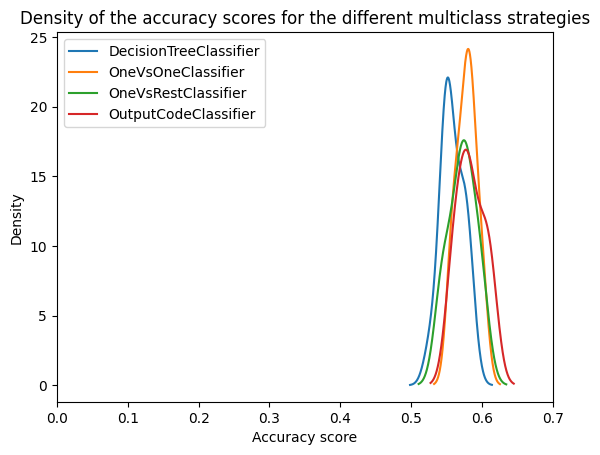

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, 5, 8]}
tree_optimized = GridSearchCV(tree, param_grid=param_grid, cv=3)
ovo_tree = OneVsOneClassifier(tree_optimized)
ovr_tree = OneVsRestClassifier(tree_optimized)
ecoc = OutputCodeClassifier(tree_optimized, code_size=2)

cv_results_tree = cross_validate(tree_optimized, X, y, cv=cv, n_jobs=2)
cv_results_ovo = cross_validate(ovo_tree, X, y, cv=cv, n_jobs=2)
cv_results_ovr = cross_validate(ovr_tree, X, y, cv=cv, n_jobs=2)
cv_results_ecoc = cross_validate(ecoc, X, y, cv=cv, n_jobs=2)

scores = pd.DataFrame(
    {
        "DecisionTreeClassifier": cv_results_tree["test_score"],
        "OneVsOneClassifier": cv_results_ovo["test_score"],
        "OneVsRestClassifier": cv_results_ovr["test_score"],
        "OutputCodeClassifier": cv_results_ecoc["test_score"],
    }
)
ax = scores.plot.kde(legend=True)
ax.set_xlabel("Accuracy score")
ax.set_xlim([0, 0.7])
_ = ax.set_title(
    "Density of the accuracy scores for the different multiclass strategies"
)

plt.show()

**Conclusion**

We can get some intuition behind those results.

First, the reason for which one-vs-one and error-correcting output code are outperforming the tree when the hyperparameters are not optimized relies on fact that they ensemble a larger number of classifiers. The ensembling improves the generalization performance. This is a bit similar why a bagging classifier generally performs better than a single decision tree if no care is taken to optimize the hyperparameters.

Then, we see the importance of optimizing the hyperparameters. Indeed, it should be regularly explored when developing predictive models even if techniques such as ensembling help at reducing this impact.

Finally, it is important to recall that the estimators in scikit-learn are developed with a specific strategy to handle multiclass classification out of the box. So for these estimators, it means that there is no need to use different strategies. These strategies are mainly useful for third-party estimators supporting only binary classification. In all cases, we also show that the hyperparameters should be optimized.